* 네거티브 샘플링(Negative Sampling)을 사용하는 Word2Vec을 직접 Keras를 통해 구현

### 1. Negative Sampling
* Word2Vec 출력층에는 소프트맥스 함수를 지난 단어 집합 크기의 벡터와 실제값인 원핫 벡터와의 오차를 구하고 이로부터 임베딩 테이블에 있는 모든 단어에 대한 임베딩 벡터값을 업데이트 함
* 만약 단어 집합 크기가 수만 이상에 달한다면 엄청 무거워짐

---
* Word2Vec은 역전파 과정에서 모든 단어의 임베딩 벡터값의 업데이트를 수행하지만, 네거티브 샘플링 방법으로 전체 단어 집합이 아닌 일부 단어 집합에만 집중할 수 있도록 함
* 예를 들어, 중심단어와 주변단어가 '강아지'와 '고양이', '귀여운' 과 같은 단어라면, 여기에 '돈가스', '회의실'과 같은 단어 집합에서 무작위로 선택된 주변 단어가 아닌 단어들을 일부 가져옴
* 이렇게 **하나의 중심단어에 대해 전체 단어집합보다 훨씬 작은 단어집합을 만들어 놓고** 마지막 단계를 이진분류 문제로 변환
* 이때, 주변단어들을 긍정(positive), 랜덤으로 샘플링 된 단어들을 부정(negative)으로 레이블링한다면 이진분류 문제를 위한 데이터셋이 됨
* 이는 기존의 단어집합의 크기만큼 선택지를 두고 다중 클래스 분류를 풀었던 기존 Word2vec보다 연산량이 훨씬 줄어듦

### 2. 네거티브 샘플링 Skip-Gram(Skip-Gram with Negative Sampling, SGNS)

* Skip-gram은 중심단어로부터 주변단어를 예측하는 모델
* 중심단어로부터 주변단어를 예측하는 방법임

---
* 그러나 네거티브 샘플링을 사용하는 Skip-gram(SGNS)는 다른 접근방법 취함
* 중심단어와 주변단어가 모두 입력되고, 입력된 두단어가 실제로 윈도우 크기 내에 존재하는 이웃관계인지 확률을 예측함

---
* 따라서 입력하는 데이터셋 만드는 방법도 달라짐
* Skip-gram은 기본적으로 중심단어를 입력, 주변단어를 레이블로 만드는 반면, SGNS에서는 중심단어와 주변단어 모두 입력단어로, 그리고 랜덤으로 상관없는 단어도 주변단어로 만듦
* 참고 : https://wikidocs.net/69141
---
#### 데이터셋이 준비되면 임베딩 데이블 준비
* 2개의 임베딩 테이블을 준비해야 하는데, 이중 하나는 입력1에 해당하는 중심단어의 테이블 룩업을 위한 임베딩 테이블
* 다른 하나는 주변단어의 테이블룩업을 위한 임베딩 테이블임
* 각 단어들은 임베딩 테이블들을 룩업하여 임베딩 벡터로 변환함. 즉개의 룩업 테이블을 거쳐 임베딩 벡터로 변환함

* 중심단어와 주변단어의 내적값을 모델의 예측값으로 하고, 레이블과의 오차로부터 역전파하여 중심단어와 주변단어의 임베딩 벡터값을 업데이트 함

* 학습 후에는 좌측의 임베딩 행렬을 임베딩 벡터로 사용할 수도 있고, 두행렬을 더한 후 사용하거나 두행렬을 연결해서 사용할 수도 있음


### 3. 20뉴스그룹 데이터 전처리


In [1]:
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
## 하나의 샘플에 최소 단어 2개는 있어야 함. 왜냐하면 중심단어, 주변단어의 관계를 만들어야 하기 때문
## 그렇지 않으면 에러 발생!!
## 따라서 전처리 과정에서 이를 만족하지 않는 샘플은 제거

In [3]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [4]:
documents[0]

"Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n"

In [7]:
### 각 문서별로 불용단어 제거하고 소문자화로 정규화 처리
news_df = pd.DataFrame(documents, columns=['document'])

## 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")  # 알파벳이 아닌 것은 공백으로

## 길이가 3이하인 단어 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))


## 전체 단어를 소문자로 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

* Null 값 확인

In [8]:
news_df.isnull().sum()

document     0
clean_doc    0
dtype: int64

* Null 값이 없지만 빈값(empty) 유무도 확인해서 Null 값으로 변환

In [9]:
news_df.replace("", float('NaN'), inplace=True)
news_df.isnull().sum()

document     218
clean_doc    319
dtype: int64

In [10]:
news_df.dropna(inplace=True)
print('총 샘플 수 :', news_df.shape[0])

총 샘플 수 : 10995


In [12]:
### 불용어 제거
stop_words = stopwords.words('english')
len(stop_words)

179

In [13]:
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [16]:
len(tokenized_doc)

10995

In [17]:
### 단어가 1개 이하인 샘플의 인덱스를 찾기
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) < 2]
len(drop_train)

55

In [18]:
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
len(tokenized_doc)

10940

In [19]:
## 샘플이 정해졌고, 코퍼스를 생성하여 정수인코딩 생성(임베딩)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

In [20]:
word2idx = tokenizer.word_index
word2idx

{'would': 1,
 'people': 2,
 'like': 3,
 'know': 4,
 'also': 5,
 'think': 6,
 'time': 7,
 'could': 8,
 'well': 9,
 'good': 10,
 'even': 11,
 'first': 12,
 'much': 13,
 'many': 14,
 'make': 15,
 'system': 16,
 'used': 17,
 'right': 18,
 'file': 19,
 'want': 20,
 'said': 21,
 'anyone': 22,
 'need': 23,
 'work': 24,
 'something': 25,
 'problem': 26,
 'since': 27,
 'please': 28,
 'information': 29,
 'year': 30,
 'back': 31,
 'using': 32,
 'really': 33,
 'program': 34,
 'going': 35,
 'still': 36,
 'years': 37,
 'find': 38,
 'believe': 39,
 'must': 40,
 'point': 41,
 'last': 42,
 'available': 43,
 'take': 44,
 'number': 45,
 'space': 46,
 'data': 47,
 'thanks': 48,
 'things': 49,
 'windows': 50,
 'government': 51,
 'might': 52,
 'made': 53,
 'another': 54,
 'mail': 55,
 'without': 56,
 'help': 57,
 'better': 58,
 'sure': 59,
 'read': 60,
 'never': 61,
 'drive': 62,
 'part': 63,
 'long': 64,
 'case': 65,
 'look': 66,
 'however': 67,
 'power': 68,
 'question': 69,
 'world': 70,
 'name': 71,
 'c

In [21]:
idx2word = {value: key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [22]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [23]:
vocab_size = len(word2idx) + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


### 4. 네거티브 샘플링을 통한 데이터셋 구성
* 네거티브 샘플링을 통한 데이터겟 구성
* 이를 위해 네거티브 샘플링을 위해 Keras의 skipgrams 사용

In [24]:
from tensorflow.keras.preprocessing.sequence import skipgrams

In [25]:
## 상위 10개 뉴스그룹 샘플만 수행
skip_gram = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

* 결과 확인..

In [26]:
type(skip_gram)

list

In [32]:
np.array(skip_gram[0]).shape

(2, 2220)

In [30]:
### 첫번째 샘플 확인
pairs, labels = skip_gram[0][0], skip_gram[0][1]

In [36]:
for i in range(5):
    print("({:s} ({:d})), {:s} ({:d})) -> {:d}".format(
        idx2word[pairs[i][0]], pairs[i][0],
        idx2word[pairs[i][1]], pairs[i][1],
        labels[i]))

(least (87)), mumath (26757)) -> 0
(letter (705)), swii (33102)) -> 0
(power (68)), sulfurous (36229)) -> 0
(ruin (9470)), media (702)) -> 1
(reason (149)), shame (4988)) -> 1


* 첫번째 뉴스그룹 샘플이 가지고 있는 pairs와 labels의 개수 출력

In [37]:
print(len(pairs))
print(len(labels))

2220
2220


In [38]:
### 모든 샘플에 대해 네거티브 샘플링 수행
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

### 5. Skip-Gram with Negative Sampling(SGNS) 구현

In [39]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [41]:
embedding_dim = 100

# 중심단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
contenxt_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

* 각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이며 각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고, 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 얻음

In [42]:
dot_product = Dot(axes=2)([word_embedding, contenxt_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

In [43]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       6427700     ['input_2[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 100)       6427700     ['input_3[0][0]']                
                                                                                              

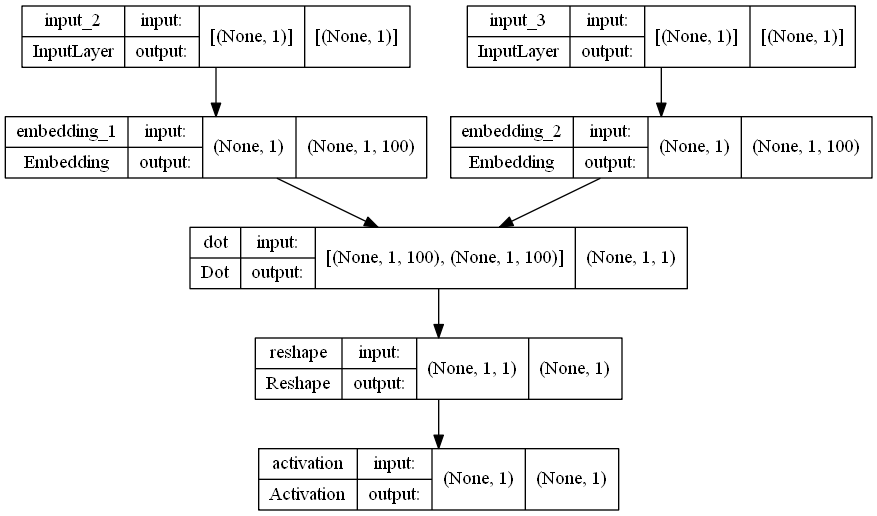

In [45]:
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [47]:
### 5 epoch 수행
for epoch in range(1, 6):
    loss = 0
    
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        
        loss += model.train_on_batch(X, Y)
        
    print('Epoch: ', epoch, 'Loss: ', loss)

Epoch:  1 Loss:  4634.834931157529
Epoch:  2 Loss:  3671.420468274504
Epoch:  3 Loss:  3498.741569634527
Epoch:  4 Loss:  3298.7198454272
Epoch:  5 Loss:  3077.201889858581


### 6. 결과 확인하기
* 학습된 임베딩 벡터들을 vector.txt에 저장
* 그후 이를 gensim의 models.KeyedVectors.load_word2vec_format()으로 로드하면 쉽게 단어 벡터간 유사도 구할 수 있음

In [49]:
import gensim

f = open('vector.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
    
f.close()

In [52]:
# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('vector.txt', binary=False)

In [53]:
w2v.most_similar(positive=['soldiers'])

[('wounded', 0.8571816682815552),
 ('inhabitants', 0.8244555592536926),
 ('shelling', 0.8190792202949524),
 ('villages', 0.8075593113899231),
 ('attackers', 0.8058263659477234),
 ('massacred', 0.7968713045120239),
 ('troops', 0.7967088222503662),
 ('systematic', 0.795072078704834),
 ('azeri', 0.7945154309272766),
 ('slaughtered', 0.7913991808891296)]

In [54]:
w2v.most_similar(positive=['doctor'])

[('pain', 0.6464951038360596),
 ('disease', 0.5776191353797913),
 ('albicans', 0.5742226839065552),
 ('patient', 0.552721381187439),
 ('breast', 0.5519615411758423),
 ('discourse', 0.5514885783195496),
 ('glutamate', 0.5434617400169373),
 ('medicine', 0.5330187082290649),
 ('dreams', 0.5317123532295227),
 ('motives', 0.5304092764854431)]

In [55]:
w2v.most_similar(positive=['police'])

[('filed', 0.5845722556114197),
 ('overwhelmingly', 0.5744795799255371),
 ('possession', 0.5570927262306213),
 ('crimes', 0.5551474690437317),
 ('denied', 0.5525658130645752),
 ('delighted', 0.5500600934028625),
 ('faced', 0.5475631356239319),
 ('homicides', 0.5444666147232056),
 ('refusal', 0.5373928546905518),
 ('violation', 0.5370625853538513)]

In [56]:
w2v.most_similar(positive=['knife'])

[('amid', 0.7481485605239868),
 ('scattered', 0.7456890344619751),
 ('grave', 0.739753782749176),
 ('agdam', 0.7343363165855408),
 ('withdrawal', 0.731659471988678),
 ('axes', 0.7281705141067505),
 ('neighboring', 0.727035641670227),
 ('biased', 0.7227190136909485),
 ('baku', 0.7224056720733643),
 ('prison', 0.7208222150802612)]

In [57]:
w2v.most_similar(positive=['engine'])

[('tires', 0.6581382155418396),
 ('cylinder', 0.6282305121421814),
 ('brakes', 0.6235031485557556),
 ('miles', 0.6233139038085938),
 ('honda', 0.6188914179801941),
 ('carb', 0.6066622734069824),
 ('rear', 0.5999491810798645),
 ('brake', 0.5802274942398071),
 ('toyota', 0.5785928964614868),
 ('pathfinder', 0.5732489824295044)]

참고
http://jalammar.github.io/illustrated-word2vec/
https://medium.com/towards-datascience/word2vec-negative-sampling-made-easy-7a1a647e07a4